In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from scr.plot import *

In [2]:
print(tf.__version__)

2.10.0


In [3]:
# Function to load data from a directory
def load_data_from_directory(directory):
    images = []
    labels = []
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'rb') as f:
            image, label = pickle.load(f)
            # Reshape or reorder image data if necessary (bands, height, width -> height, width, bands)
            image = np.transpose(image, (1, 2, 0))
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Paths to your data directories
train_dir = "data/classification_dataset/train"
validation_dir = "data/classification_dataset/validation"
test_dir = "data/classification_dataset/test"

# Load the data
train_images, train_labels = load_data_from_directory(train_dir)
val_images, val_labels = load_data_from_directory(validation_dir)
test_images, test_labels = load_data_from_directory(test_dir)

# Convert data to tf.data.Dataset
def create_tf_dataset(images, labels):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    return dataset

train_dataset = create_tf_dataset(train_images, train_labels)
validation_dataset = create_tf_dataset(val_images, val_labels)
test_dataset = create_tf_dataset(test_images, test_labels)

# Batch and shuffle the datasets
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [4]:
print(len(train_images), len(val_images), len(test_images))

53535 7436 13386


(32, 32, 12) 0


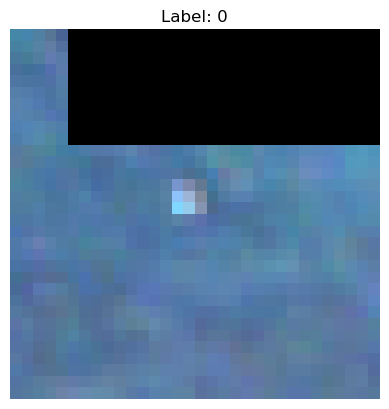

In [5]:
for images, labels in train_dataset.take(1):
    for i in range(1):
        print(images[i].shape, labels[i].numpy())
        image = images[i]
        label = labels[i]

        # Reshape or reorder image data if necessary (bands, height, width -> height, width, bands)
        #image = np.transpose(image, (1, 2, 0))  # (12, 32, 32) -> (32, 32, 12)

        # Select RGB bands (e.g., bands 4, 3, 2 from Sentinel-2, adjust if needed)
        rgb_image = np.stack([
            image[:, :, 3],  # Band 4 (Red)
            image[:, :, 2],  # Band 3 (Green)
            image[:, :, 1]   # Band 2 (Blue)
        ], axis=-1)
        
        # Normalize the RGB image for saving
        rgb_image = (rgb_image / np.max(rgb_image) * 255).astype(np.uint8)

        # Save the image as a TIFF file
        # tiff.imwrite('rgb_image.tiff', rgb_image)
        # print("Image saved as 'rgb_image.tiff'")

        # Display the RGB image
        plt.imshow(rgb_image)
        plt.title(f"Label: {label.numpy()}")
        plt.axis("off")
        plt.show()


In [6]:
img_height = 32
img_width = 32
batch_size = 32

In [7]:
num_classes = 2

model = Sequential([
  layers.Conv2D(16, 12, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 12, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 12, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
epochs=10
history_no_classweights = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)
# no_classweights_10_ephocs

Epoch 1/10


2024-12-23 00:14:43.950905: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1673/1673 [==============================] - 130s 77ms/step - loss: 0.2801 - accuracy: 0.8576 - val_loss: 0.7660 - val_accuracy: 0.5724
Epoch 2/10
1673/1673 [==============================] - 131s 78ms/step - loss: 0.2489 - accuracy: 0.8814 - val_loss: 0.5092 - val_accuracy: 0.7070
Epoch 3/10
1673/1673 [==============================] - 132s 79ms/step - loss: 0.2117 - accuracy: 0.8996 - val_loss: 0.4023 - val_accuracy: 0.8066
Epoch 4/10
1673/1673 [==============================] - 134s 80ms/step - loss: 0.1897 - accuracy: 0.9098 - val_loss: 0.3498 - val_accuracy: 0.8331
Epoch 5/10
1673/1673 [==============================] - 290s 173ms/step - loss: 0.1893 - accuracy: 0.9120 - val_loss: 0.3193 - val_accuracy: 0.8614
Epoch 6/10
1673/1673 [==============================] - 1797s 1s/step - loss: 0.1794 - accuracy: 0.9154 - val_loss: 0.3681 - val_accuracy: 0.8263
Epoch 7/10
1673/1673 [==============================] - 132s 79ms/step - loss: 0.1764 - accuracy: 0.9170 - val_loss: 0.3611 - val

In [10]:
# Save the model
tf.keras.models.save_model(model, 'no_classweights_10_epochs.keras', overwrite=True)

In [11]:
#plotting confusion matrix
model_no_classweights = tf.keras.models.load_model('no_classweights_10_epochs.keras')

233/233 [==============================] - 5s 22ms/step


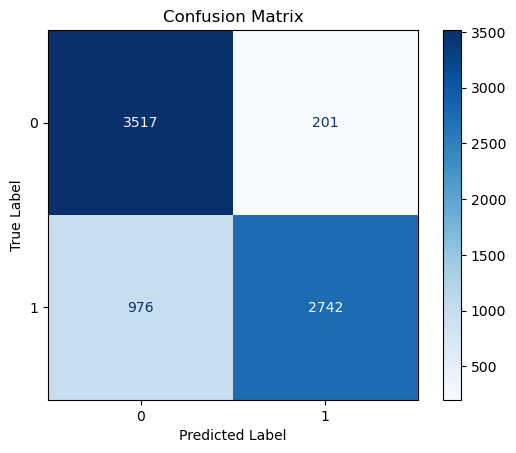

In [12]:
confusion_matrix_plot(model_no_classweights,validation_dataset)

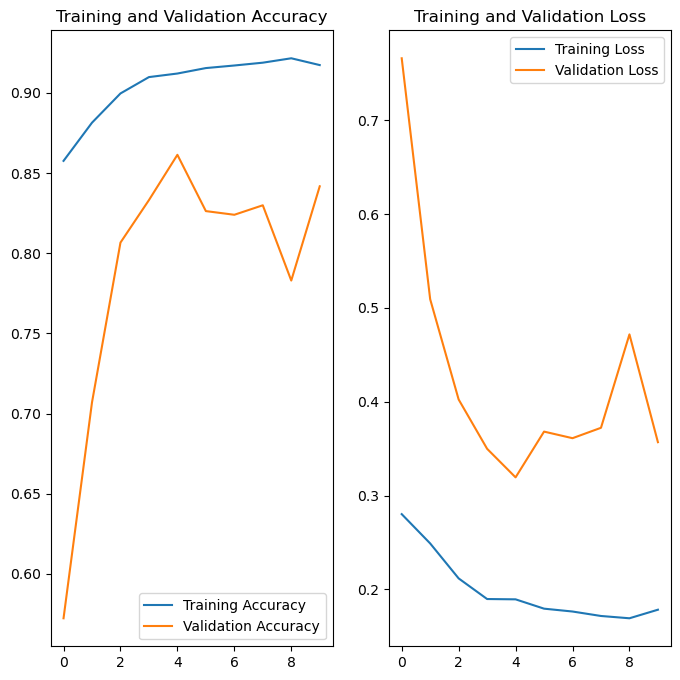

In [13]:
plot_results(history_no_classweights, epochs)

## Training with class weights

In [14]:
def calculate_class_weights(dataset):
    # Extract all labels from the dataset
    all_labels = []
    for _, labels in dataset:
        all_labels.extend(labels.numpy())

    # Count the occurrences of each class
    label_counts = Counter(all_labels)

    # Total number of samples
    total_samples = sum(label_counts.values())

    # Calculate weights for each class
    class_weights = {label: total_samples / (len(label_counts) * count) 
                     for label, count in label_counts.items()}

    return class_weights

# Calculate class weights for the train_dataset
class_weights = calculate_class_weights(train_dataset)
print("Class Weights:", class_weights)

Class Weights: {0: 0.5864792620670012, 1: 3.390866480871548}


In [15]:
epochs=10
history_classweights = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs,
  class_weight = class_weights
)

Epoch 1/10
1673/1673 [==============================] - 148s 88ms/step - loss: 0.2366 - accuracy: 0.8773 - val_loss: 0.2228 - val_accuracy: 0.9090
Epoch 2/10
1673/1673 [==============================] - 160s 96ms/step - loss: 0.2195 - accuracy: 0.8848 - val_loss: 0.2224 - val_accuracy: 0.9134
Epoch 3/10
1673/1673 [==============================] - 171s 102ms/step - loss: 0.2094 - accuracy: 0.8869 - val_loss: 0.2284 - val_accuracy: 0.9115
Epoch 4/10
1673/1673 [==============================] - 148s 89ms/step - loss: 0.2048 - accuracy: 0.8892 - val_loss: 0.2254 - val_accuracy: 0.9125
Epoch 5/10
1673/1673 [==============================] - 152s 91ms/step - loss: 0.2029 - accuracy: 0.8908 - val_loss: 0.2360 - val_accuracy: 0.9072
Epoch 6/10
1673/1673 [==============================] - 154s 92ms/step - loss: 0.2038 - accuracy: 0.8923 - val_loss: 0.2203 - val_accuracy: 0.9146
Epoch 7/10
1673/1673 [==============================] - 156s 93ms/step - loss: 0.1958 - accuracy: 0.8937 - val_loss: 

In [16]:
model.save('with_classweights_10_epochs.keras')
model_classweights = tf.keras.models.load_model('with_classweights_10_epochs.keras')

233/233 [==============================] - 6s 25ms/step


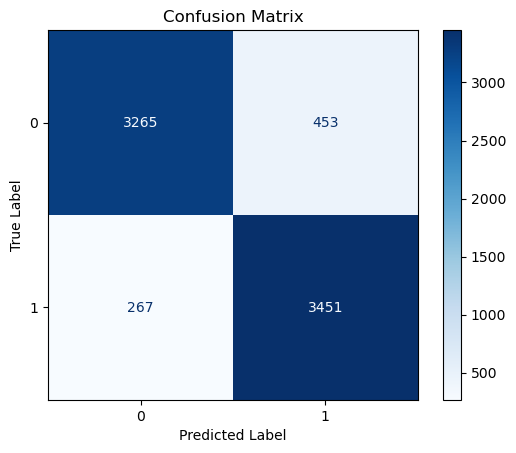

In [17]:
confusion_matrix_plot(model_classweights,validation_dataset)

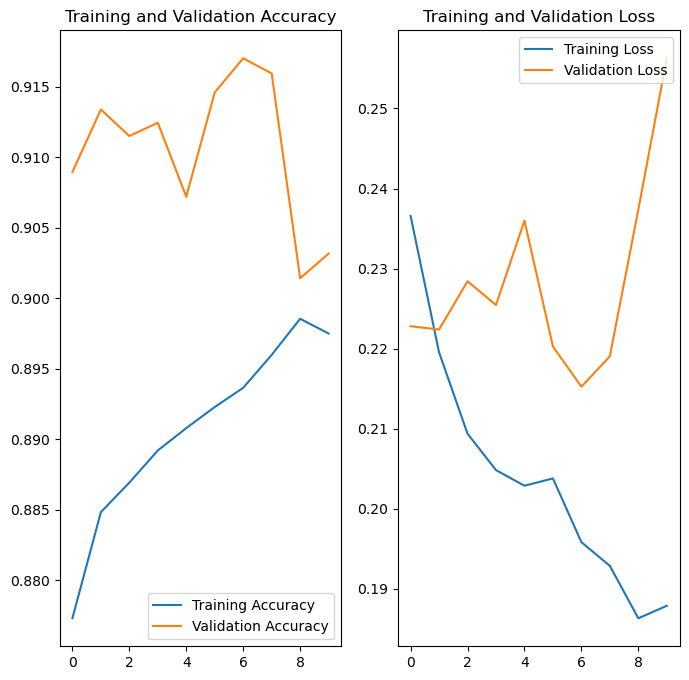

In [18]:
plot_results(history_classweights,epochs)

### Adding data augmentation to model

In [19]:
model_augment = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  layers.Conv2D(16, 12, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 12, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 12, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model_augment.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
history_classweights_augment = model_augment.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs,
  class_weight = class_weights
)

Epoch 1/10
1673/1673 [==============================] - 157s 93ms/step - loss: 0.3939 - accuracy: 0.7152 - val_loss: 0.3673 - val_accuracy: 0.8310
Epoch 2/10
1673/1673 [==============================] - 155s 92ms/step - loss: 0.3593 - accuracy: 0.7379 - val_loss: 0.3274 - val_accuracy: 0.8397
Epoch 3/10
1673/1673 [==============================] - 155s 93ms/step - loss: 0.3089 - accuracy: 0.8098 - val_loss: 0.2654 - val_accuracy: 0.8936
Epoch 4/10
1673/1673 [==============================] - 163s 98ms/step - loss: 0.2829 - accuracy: 0.8420 - val_loss: 0.2955 - val_accuracy: 0.8761
Epoch 5/10
1673/1673 [==============================] - 164s 98ms/step - loss: 0.2774 - accuracy: 0.8452 - val_loss: 0.2892 - val_accuracy: 0.8597
Epoch 6/10
1673/1673 [==============================] - 168s 100ms/step - loss: 0.2684 - accuracy: 0.8495 - val_loss: 0.2438 - val_accuracy: 0.8998
Epoch 7/10
1673/1673 [==============================] - 168s 101ms/step - loss: 0.2600 - accuracy: 0.8579 - val_loss:

In [31]:
model_augment.save('augment_with_classweights_10_epochs.keras')
model_augment_classweights = tf.keras.models.load_model('augment_with_classweights_10_epochs.keras')

233/233 [==============================] - 4s 17ms/step


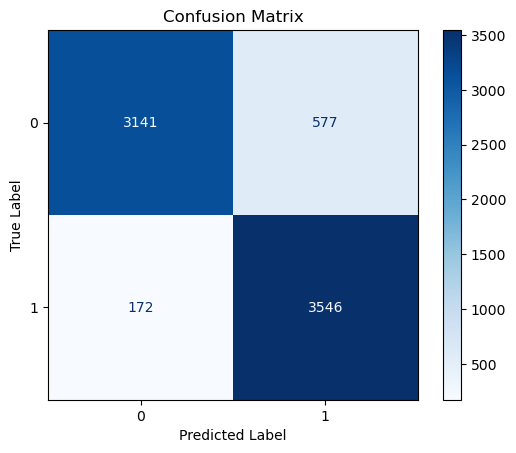

In [32]:
confusion_matrix_plot(model_augment_classweights,validation_dataset)

### RGB + NIR image

In [21]:
def filter_rgb_nir(images):
    return images[:, :, :, [3, 2, 1, 7]]  # Bands: Red (4), Green (3), Blue (2), NIR (8)

# Filter datasets
train_images_rgb_nir = filter_rgb_nir(train_images)
val_images_rgb_nir = filter_rgb_nir(val_images)
test_images_rgb_nir = filter_rgb_nir(test_images)

# Define the model for RGB + NIR bands
model_rgb_nir = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    layers.Conv2D(16, 12, padding='same', activation='relu', input_shape=(32, 32, 4)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 12, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 12, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2)  # Binary classification
])

# Compile the model
model_rgb_nir.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [22]:
# Convert the filtered data to TensorFlow datasets
train_dataset_rgb_nir = tf.data.Dataset.from_tensor_slices((train_images_rgb_nir, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
validation_dataset_rgb_nir = tf.data.Dataset.from_tensor_slices((val_images_rgb_nir, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

# Train the model
history_rgb_nir = model_rgb_nir.fit(
    train_dataset_rgb_nir,
    validation_data=validation_dataset_rgb_nir,
    epochs=10,
    class_weight=class_weights
)

# Save the model
model_rgb_nir.save('model_rgb_nir.keras')

Epoch 1/10
1673/1673 [==============================] - 123s 73ms/step - loss: 0.4095 - accuracy: 0.6997 - val_loss: 0.3863 - val_accuracy: 0.8246
Epoch 2/10
1673/1673 [==============================] - 121s 72ms/step - loss: 0.3955 - accuracy: 0.7014 - val_loss: 0.3835 - val_accuracy: 0.8254
Epoch 3/10
1673/1673 [==============================] - 122s 73ms/step - loss: 0.3924 - accuracy: 0.7047 - val_loss: 0.3849 - val_accuracy: 0.8234
Epoch 4/10
1673/1673 [==============================] - 122s 73ms/step - loss: 0.3761 - accuracy: 0.7093 - val_loss: 0.3394 - val_accuracy: 0.8401
Epoch 5/10
1673/1673 [==============================] - 122s 73ms/step - loss: 0.3374 - accuracy: 0.7512 - val_loss: 0.3015 - val_accuracy: 0.8464
Epoch 6/10
1673/1673 [==============================] - 124s 74ms/step - loss: 0.3147 - accuracy: 0.7895 - val_loss: 0.3099 - val_accuracy: 0.8436
Epoch 7/10
1673/1673 [==============================] - 123s 74ms/step - loss: 0.2992 - accuracy: 0.8221 - val_loss: 0

In [23]:
tf.keras.models.save_model(
    model_rgb_nir, 'model_rgb_nir_10_epochs.keras', overwrite=True)

233/233 [==============================] - 4s 19ms/step


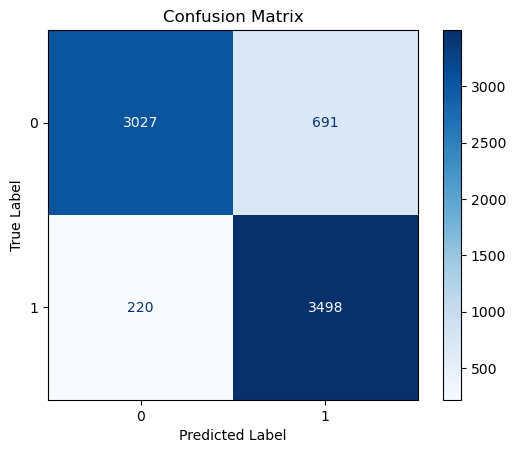

In [24]:
# True labels and predictions
y_true = np.concatenate([y for x, y in validation_dataset_rgb_nir], axis=0)  
y_pred = np.argmax(model_rgb_nir.predict(validation_dataset_rgb_nir), axis=1)       

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

# Customize plot (optional)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [25]:
# Filter only RGB bands
def filter_rgb(images):
    return images[:, :, :, [3, 2, 1]]  # Bands: Red (4), Green (3), Blue (2)

# Filter datasets
train_images_rgb = filter_rgb(train_images)
val_images_rgb = filter_rgb(val_images)
test_images_rgb = filter_rgb(test_images)

In [26]:
# Define the model for RGB bands
model_rgb = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    layers.Conv2D(16, 12, padding='same', activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 12, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 12, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2)  # Binary classification
])

# Compile the model
model_rgb.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Convert the filtered data to TensorFlow datasets
train_dataset_rgb = tf.data.Dataset.from_tensor_slices((train_images_rgb, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
validation_dataset_rgb = tf.data.Dataset.from_tensor_slices((val_images_rgb, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

# Train the model
history_rgb = model_rgb.fit(
    train_dataset_rgb,
    validation_data=validation_dataset_rgb,
    epochs=10,
    class_weight=class_weights
)

# Save the model
model_rgb.save('model_rgb.keras')

Epoch 1/10
1673/1673 [==============================] - 132s 77ms/step - loss: 0.4158 - accuracy: 0.6913 - val_loss: 0.4005 - val_accuracy: 0.8187
Epoch 2/10
1673/1673 [==============================] - 127s 76ms/step - loss: 0.4037 - accuracy: 0.6911 - val_loss: 0.4060 - val_accuracy: 0.8119
Epoch 3/10
1673/1673 [==============================] - 1968s 1s/step - loss: 0.4143 - accuracy: 0.6885 - val_loss: 0.3961 - val_accuracy: 0.8175
Epoch 4/10
1673/1673 [==============================] - 107s 64ms/step - loss: 0.3984 - accuracy: 0.6993 - val_loss: 0.4024 - val_accuracy: 0.8156
Epoch 5/10
1673/1673 [==============================] - 109s 65ms/step - loss: 0.3964 - accuracy: 0.6994 - val_loss: 0.3953 - val_accuracy: 0.8205
Epoch 6/10
1673/1673 [==============================] - 109s 65ms/step - loss: 0.3998 - accuracy: 0.6996 - val_loss: 0.3939 - val_accuracy: 0.8232
Epoch 7/10
1673/1673 [==============================] - 110s 66ms/step - loss: 0.3976 - accuracy: 0.6995 - val_loss: 0.

In [27]:
tf.keras.models.save_model(
    model_rgb, 'model_rgb_10_epochs.keras', overwrite=True)

233/233 [==============================] - 4s 18ms/step


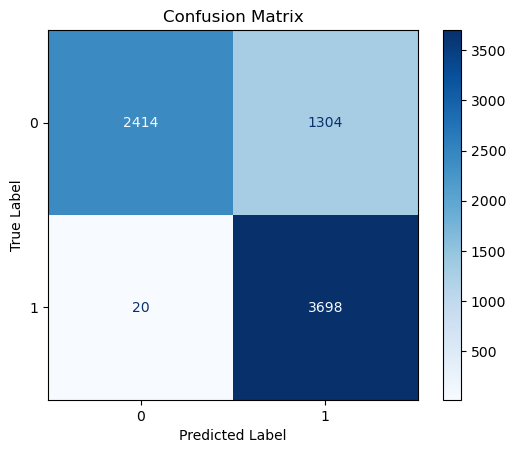

In [28]:
# True labels and predictions
y_true = np.concatenate([y for x, y in validation_dataset_rgb], axis=0)  
y_pred = np.argmax(model_rgb.predict(validation_dataset_rgb), axis=1)       

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

# Customize plot (optional)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()